In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CHRONOSTRAIN_INI=/home/youn/work/chronostrain/examples/umb/files/chronostrain.ini
%env CHRONOSTRAIN_DB_JSON=/mnt/e/ecoli_db/chronostrain_files/ecoli.json
%env CHRONOSTRAIN_DB_DIR=/mnt/e/ecoli_db/chronostrain_files
%env CHRONOSTRAIN_CACHE_DIR=./cache
%env CHRONOSTRAIN_LOG_INI=./logging.ini
%env JAX_PLATFORM_NAME=cpu


from typing import *
from pathlib import Path
import numpy as np
import jax
import pandas as pd

from chronostrain.config import cfg
from chronostrain.database import *
from chronostrain.inference import *

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as patches
import matplotlib.transforms as mtransforms
from matplotlib import gridspec
import string
import seaborn as sb
import scipy

from Bio import Phylo
from helpers import *

env: CHRONOSTRAIN_INI=/home/youn/work/chronostrain/examples/umb/files/chronostrain.ini
env: CHRONOSTRAIN_DB_JSON=/mnt/e/ecoli_db/chronostrain_files/ecoli.json
env: CHRONOSTRAIN_DB_DIR=/mnt/e/ecoli_db/chronostrain_files
env: CHRONOSTRAIN_CACHE_DIR=./cache
env: CHRONOSTRAIN_LOG_INI=./logging.ini
env: JAX_PLATFORM_NAME=cpu


In [3]:
# Ensure that basic bash commands work.

try:
    VARS_SET
except NameError:
    VARS_SET = True
    _cwd = %pwd
    _parent_cwd = Path(_cwd).parent
    _start_path = %env PATH
    %env PATH=$_start_path:/usr/bin


# zcat is needed by bowtie2
# !zcat --version  # if this doesn't work, then install "gzip" (e.g. conda install -c conda-forge gzip)

env: PATH=/home/youn/mambaforge/envs/chronostrain2/bin:/usr/bin


# Phylogroup-based labelling/coloring

In [4]:
def annotate_phylogroups(db: StrainDatabase, phylogroup_path: Path):
    """To each strain, add a phylogroup annotation."""
    for strain in db.all_strains():
        strain.phylogroup = '?'
    
    with open(phylogroup_path, 'r') as f:
        for line in f:
            tokens = line.strip().split('\t')
            accession = Path(tokens[0]).with_suffix('').with_suffix('').name
            phylogroup = tokens[4]
            try:
                db.get_strain(accession).phylogroup = phylogroup
            except QueryNotFoundError:
                pass
    

def create_palette(db: StrainDatabase):
    palette_tab20 = sb.color_palette("tab20", 20)
    phylogroup_colors = {
        'A': palette_tab20[4],
        'B1': palette_tab20[1],
        'B2': palette_tab20[6],
        'C': palette_tab20[0],
        'D': 'gold',
        'E': palette_tab20[8],
        'F': palette_tab20[7],
        'G': palette_tab20[5],
        'fergusonii': palette_tab20[2],
        'albertii': palette_tab20[3],
        'E or cladeI': palette_tab20[9],
        'cladeI': palette_tab20[10],
        'Unknown': palette_tab20[11],
        'cladeV': palette_tab20[12],
        '?': np.array([0.0, 0.0, 0.0, 1.0])
    }
    strain_colors = {
        s.id: phylogroup_colors[s.phylogroup]
        for s in db.all_strains()
    }
    return phylogroup_colors, strain_colors

In [5]:
db = cfg.database_cfg.get_database()
cluster_path = Path("/mnt/e/ecoli_db/chronostrain_files/ecoli.clusters.txt")
annotate_phylogroups(db, phylogroup_path=Path("/mnt/e/ecoli_db/phylogeny/ClermonTyping/umb_phylogroups_complete.txt"))
clades = [
    "A", "B1", "B2", "C", "D", "E", "F", "G", 
    "fergusonii", "albertii", "E or cladeI", "cladeI", "Unknown", "cladeV",
    "N/A"
]
phylo_colors, strain_colors = create_palette(db)

abx_acronym = {'nitrofuran': 'N', 'fluoroquinolone': 'F', 'beta_lactam': 'B', 'sulfonamide': 'S', 'macrolide': 'M', 'tetracycline': 'T'}
abx_colors = {'nitrofuran': 'red', 'fluoroquinolone': 'magenta', 'beta_lactam': 'green', 'sulfonamide': 'blue', 'macrolide': 'cyan', 'tetracycline': 'orange'}
abx_labels = {'nitrofuran': 'Nitrofurantoin', 'fluoroquinolone': 'Fluoroquinolone', 'beta_lactam': 'Beta Lactam', 'sulfonamide': 'Sulfonamide', 'macrolide': 'Macrolide', 'tetracycline': 'Tetracycline'}
index_df = pd.read_csv("/mnt/e/ecoli_db/ref_genomes/index.tsv", sep='\t')

# StrainGST stuff

In [6]:
# ======================================= Parsing
umb_entries = parse_umb_entries(
    straingst_output_basedir=Path("/data/cctm/youn/umb"),
    entries_csv_path=Path().resolve().parent / 'files' / 'umb_samples.csv'
)
umb_dates_df = retrieve_patient_dates(umb_entries)
straingst_df = straingst_dataframe(
    umb_entries,
    Path("/mnt/e/ecoli_db/phylogeny/ClermonTyping/umb_phylogroups_complete.txt")
)

UMB entry `UMB04_05` reported species `marmotae` (accession=NZ_LR134340.1). Skipping.
UMB entry `UMB04_06` reported species `marmotae` (accession=NZ_LR134340.1). Skipping.
UMB entry `UMB20_12` reported species `flexneri` (accession=NZ_CP058796.1). Skipping.
UMB entry `UMB28_04` reported species `flexneri` (accession=NZ_CP055219.1). Skipping.
UMB entry `UMB28_06` reported species `flexneri` (accession=NZ_CP055170.1). Skipping.
UMB entry `UMB_24_03` reported species `flexneri` (accession=NZ_CP055170.1). Skipping.
UMB entry `UMB_24_03_2` reported species `flexneri` (accession=NZ_CP055170.1). Skipping.


# Plot helper

In [7]:
def add_figure_labels(fig, axes):
    """ add A/B/C/D labels """
    for n, _ax in enumerate(axes):
        # _ax.text(-.1, 1.1, string.ascii_uppercase[n], transform=_ax.transAxes, size=20, weight='bold')
        trans = mtransforms.ScaledTranslation(-25/72, -3/72, fig.dpi_scale_trans)
        _ax.text(0, 1, string.ascii_lowercase[n], transform=_ax.transAxes + trans,
                 va='bottom', fontfamily='sans-serif', weight='bold', size=15)

# Function for plotting UMB

In [8]:
base_dir = Path("/data/cctm/youn/umb")
# bf_threshold = 19000.0
# prior_p = 0.001
posterior_threshold = 0.95
print("Using posterior threshold =", posterior_threshold)


metadata_df = pd.read_csv(Path("/home/youn/work/chronostrain/examples/umb/files/umb_samples.csv"))


# ====== Load results
res_cache = {}

def load_result(umb_id):
    if umb_id in res_cache:
        return
    res = {}
    try:
        res['stool'] = ChronostrainResult(
            umb_id,
            db, 
            GaussianStrainCorrelatedWithGlobalZerosPosterior,
            base_dir / 'stool' / umb_id / 'chronostrain', 
            base_dir / 'stool' / umb_id / 'filtered' / 'filtered_reads.csv',
            posterior_threshold=posterior_threshold
        )
    except FileNotFoundError as e:
        print(f"File error while loading stool: {str(e)}")
        res['stool'] = None

    try:
        res['urine'] = ChronostrainResult(
            umb_id,
            db, 
            GaussianStrainCorrelatedWithGlobalZerosPosterior,
            base_dir / 'urine' / umb_id / 'chronostrain', 
            base_dir / 'urine' / umb_id / 'filtered' / 'filtered_reads.csv',
            posterior_threshold=posterior_threshold
        )
    except FileNotFoundError as e:
        print(f"File error while loading urine: {str(e)}")
        res['urine'] = None

    plate_res = []
    umb_number = umb_id[3:]
    plate_prefix = "Esch_coli_UMB_{}_".format(umb_number)
    for f in (base_dir / 'plate_scrapes' / 'split_samples_run').glob(f'{plate_prefix}*'):
        sample_str = f.name[len(plate_prefix):]
        timepoint_id = sample_str.split("_")[0]
        print("Found plate {} -> timepoint_id {}".format(f.name, timepoint_id))
        row = metadata_df.loc[metadata_df['SampleName'] == f'{umb_id}_{timepoint_id}', 'days']
        plate_t = row.item()
        try:
            plate_res.append(
                (
                    plate_t, ChronostrainResult(
                        umb_id,
                        db, 
                        GaussianStrainCorrelatedWithGlobalZerosPosterior,
                        f / 'chronostrain', 
                        f / 'filtered' / 'filtered_reads.csv',
                        posterior_threshold=posterior_threshold
                    )
                )
            )
        except FileNotFoundError as e:
            print(f"File error while loading plate: {f.name}")
    res['plate'] = plate_res
    res_cache[umb_id] = res

Using posterior threshold = 0.95


In [9]:
def load_abx_df(umb_id) -> pd.DataFrame:
    abx_df = pd.read_csv(Path().resolve().parent / 'files' / 'abx_table.tsv', sep="\t").astype(
        dtype={
            'experiment_day_ended': 'int64',
            'date_ended': 'datetime64[ns]'
        }
    )
    umb_df = pd.read_csv(Path(Path().resolve().parent / 'files' / 'umb_samples.csv'))
    umb_dates = umb_df.groupby('ID').head(1)[['ID', 'date', 'days']].astype({'date': 'datetime64[ns]'})
    umb_dates.columns = ['ID', 'ref_date', 'ref_days']

    abx_df = abx_df.merge(umb_dates, left_on='patient_id', right_on='ID')
    abx_df['experiment_day_ended'] = (abx_df['date_ended'] - abx_df['ref_date']).dt.days + abx_df['ref_days']
    abx_df = abx_df[['patient_id', 'raw_abx', 'clean_abx', 'abx_class', 'date', 'days_before', 'weeks_before', 'date_ended', 'experiment_day_ended']]
    return abx_df.loc[abx_df['patient_id'] == umb_id]


def load_uti_df(umb_id) -> pd.DataFrame:
    uti_df = pd.read_csv(Path().resolve().parent / 'files' / 'utis.csv').astype({'UTIDate': 'datetime64[ns]'})
    uti_df = uti_df.loc[uti_df['Patient'] == umb_id]
    
    umb_df = pd.read_csv(Path(Path().resolve().parent / 'files' / 'umb_samples.csv'))
    umb_dates = umb_df.groupby('ID').head(1)[['ID', 'date', 'days']].astype({'date': 'datetime64[ns]'})
    umb_dates.columns = ['ID', 'ref_date', 'ref_days']
    
    uti_df = uti_df.merge(umb_dates, left_on='Patient', right_on='ID')
    uti_df['UTIDay'] = (uti_df['UTIDate'] - uti_df['ref_date']).dt.days + uti_df['ref_days']
    uti_df = uti_df[['Patient', 'UTIDate', 'UTIDay']]
    
    return uti_df


def load_sample_df(umb_id) -> pd.DataFrame:
    df = pd.read_csv(Path().resolve().parent / 'files' / "umb_samples.csv", sep=',').astype({
        'date': 'datetime64[ns]'
    })
    df['T'] = df['days']
    return df.loc[df['ID'] == umb_id, ['Run', 'ID', 'SampleName', 'date', 'Group', 'type', 'T']]

In [14]:
def plot_umb(
    umb_id: str, 
    base_dir: Path, 
    seed: int, 
    result_cache: Dict[str, Dict[str, ChronostrainResult]], 
    abund_lb: float, 
    width: float, 
    include_straingst: bool,
    chronostrain_strain_linestyles: Dict = {},
    straingst_strain_linestyles: Dict = {}
):
    cfg.engine_cfg.prng_key = jax.random.PRNGKey(seed)  # for reproducibility
    res = result_cache[umb_id]
    stool_result = res['stool']
    urine_result = res.get('urine', None)
    plate_results = res.get('plate', [])
        
        
    plotter = ChronostrainRenderer(
        db=db,
        cluster_path=cluster_path,
        abund_lb=abund_lb, 
        target_taxon=Taxon("Escherichia", "coli"), 
        strain_palette=strain_colors,
        stool_result=stool_result,
        urine_result=urine_result,
        plate_results=plate_results,
        abx_df=load_abx_df(umb_id),
        abx_palette=abx_colors,
        abx_label=abx_acronym,
        uti_df=load_uti_df(umb_id),
        sample_df=load_sample_df(umb_id)
    )
    
    sb.set_style("whitegrid")
    chr_df = plotter.get_merged_df()

    if not include_straingst:
        scatterplot_n_taxa = len(pd.unique(chr_df['StrainId']))
        scatterplot_ht_scale = scatterplot_n_taxa / 8
        fig = plt.figure(constrained_layout=True, figsize=(width, 2.0 * (1.2 + scatterplot_ht_scale) + 5.0))
        gs = gridspec.GridSpec(ncols=2, nrows=3, figure=fig, height_ratios=[0.7, scatterplot_ht_scale, 1], width_ratios=[1, 2])
    else:
        scatterplot_n_taxa_chronostrain = len(pd.unique(chr_df['StrainId']))
        scatterplot_ht_scale_chronostrain = scatterplot_n_taxa_chronostrain / 8

        straingst_res_umb = straingst_df.loc[straingst_df['Patient'] == umb_id]
        scatterplot_n_taxa_straingst = len(pd.unique(straingst_res_umb['StrainId']))
        scatterplot_ht_scale_straingst = scatterplot_n_taxa_straingst / 8
        
        fig = plt.figure(constrained_layout=True, figsize=(width, 2.0 * (1.2 + scatterplot_ht_scale_chronostrain + scatterplot_ht_scale_straingst) + 5.0))
        gs = gridspec.GridSpec(ncols=2, nrows=5, figure=fig, height_ratios=[0.7, scatterplot_ht_scale_chronostrain, 1, scatterplot_ht_scale_straingst, 1], width_ratios=[1, 2])
        

    # ====================== legend axis
    legend_ax = fig.add_subplot(gs[0, :])
    legends = []
    
    # ====================== Phylogroup legend
    clade_subset = set(db.get_strain(s_id).phylogroup for s_id in set(pd.unique(chr_df['StrainId'])))
    clade_list = [c for c in clades if c in clade_subset] #['A', 'B1', 'B2', 'C', 'D', 'E', 'F', 'G', 'E or cladeI', 'cladeI', 'cladeV', 'Unknown']
    handles, labels = zip(*[
        (patches.Patch(facecolor=phylo_colors[p], edgecolor='white'), p)
        #(legend_ax.scatter([], [], facecolors=phylo_colors[p]), p) 
        for p in clade_list
    ])
    phylogroup_legend = plt.legend(handles, labels, title="Phylogroup", bbox_to_anchor=(-0.00, 0.5), loc="center left", ncol=5)
    legends.append(phylogroup_legend)

    # ====================== ABX Legend
    def create_text_legend_proxy(label, color):
        """
        Hack to use Letter-based markers for legend creation
        """
        t = matplotlib.textpath.TextPath(xy=(0, -.2), s=label, size=0.5)
        line = matplotlib.lines.Line2D(
            [0], [-1], linestyle='none',
            marker=t, markeredgecolor=color, markerfacecolor=color, markersize=20.0, markeredgewidth=0.1,
        )
        return line
    
    _abx = set(pd.unique(plotter.abx_df['abx_class']))
    abx_lbls = [
        (
            create_text_legend_proxy(abx_acronym[abx_name], abx_colors[abx_name]),
            abx_label
        )
        for abx_name, abx_label in abx_labels.items()
        if abx_name in _abx
    ]
    if len(abx_lbls) > 0:
        handles, labels = zip(*abx_lbls)
        abx_legend = plt.legend(handles, labels, title="Antibiotics", bbox_to_anchor=(0.435, 0.5), loc="center left", ncol=3)
        legends.append(abx_legend)

    # ====================== Scatter legend
    handles, labels = zip(*[
        (legend_ax.scatter([], [], color='black', marker='o', facecolors=[1, 1, 1, 0], linewidths=2, s=200), 'Stool'),
        (legend_ax.scatter([], [], color='black', marker='.', linewidths=1.5, s=100), 'Urine'),
        (legend_ax.scatter([], [], color='black', marker='x', linewidths=2, s=200), 'MacConkey') 
    ])
    scatter_legend = plt.legend(handles, labels, title="Filtered Calls", bbox_to_anchor=(1.0, 0.5), loc="center right", ncol=6)
    legends.append(phylogroup_legend)

    # ======================= Render legends
    legend_ax.axis('off')
    for legend in legends:
        legend_ax.add_artist(legend)

    fig_axes = []
    # ===================== Tree
    marker_tree = Phylo.read(str("/mnt/e/ecoli_db/phylogeny/tree/tree.nwk"), "newick")
    marker_tree.ladderize()
    tree_ax = fig.add_subplot(gs[1, 0])
    x_posns, y_posns = plotter.plot_tree(
        ax=tree_ax,
        tree=marker_tree
    )
    tree_ax.set_title("Marker distance")
    fig_axes.append(tree_ax)

    
    timeseries_axes = []
    # ===================== Clade marker scatterplots
    marker_sz = 0.5 # scatterplot marker size
    scatter_ax = fig.add_subplot(gs[1, 1])
    timeseries_axes.append(scatter_ax)
    # pre-compute ordering.
    y_ordering = [(clade.name, y_pos) for clade, y_pos in y_posns.items() if clade.is_terminal()]
    y_ordering = sorted(y_ordering, key=lambda p: p[1])
    y_ordering = {
        acc: len(y_ordering) - y_idx
        for y_idx, (acc, y_pos) in enumerate(y_ordering)
    }
    plotter.plot_clade_presence(
        scatter_ax, strain_y=y_ordering
    )
    fig_axes.append(scatter_ax)
    
    # ===================== Relative Abundance lineplot
    abund_ax = fig.add_subplot(gs[2, 1])
    timeseries_axes.append(abund_ax)
    ymin, ymax = plotter.plot_overall_relabund(abund_ax, mode='stool', strain_linestyles=chronostrain_strain_linestyles)
    abund_ax.set_ylim(bottom=max(ymin, 1e-7), top=min(ymax*10, 1.0))
    scatter_ax.sharex(abund_ax)
    fig_axes.append(abund_ax)

    if include_straingst:
        tree_ax2 = fig.add_subplot(gs[3, 0])
        mash_tree = Phylo.read(str("/mnt/e/ecoli_db/phylogeny/tree/mash_tree.nwk"), "newick")
        mash_tree.ladderize()
        _, straingst_y_posns = plot_tree(straingst_res_umb, phylo_colors, tree_ax2, mash_tree)
        tree_ax2.set_title("Whole-genome distance")
        straingst_y_ordering = [(clade.name, y_pos) for clade, y_pos in straingst_y_posns.items() if clade.is_terminal()]
        straingst_y_ordering = sorted(straingst_y_ordering, key=lambda p: p[1])
        straingst_y_ordering = {
            acc: len(straingst_y_ordering) - y_idx
            for y_idx, (acc, y_pos) in enumerate(straingst_y_ordering)
        }

        clade_ax2 = fig.add_subplot(gs[3, 1])
        if scatterplot_n_taxa_straingst > 0:
            plot_clade_presence(
                straingst_res_umb, 
                umb_dates_df.loc[umb_dates_df['Patient'] == umb_id],
                phylo_colors,
                clade_ax2,
                strain_y=straingst_y_ordering,
                show_ylabels=True
            )
        else:
            clade_ax2.set_yticks([])
        clade_ax2.sharex(abund_ax)
        timeseries_axes.append(clade_ax2)
        
        abund_ax2 = fig.add_subplot(gs[4, 1])
        plot_straingst_abundances(
            straingst_res_umb, 
            umb_dates_df.loc[umb_dates_df['Patient'] == umb_id],
            phylo_colors,  abund_ax2, mode='stool', yscale='log',
            strain_linestyles=straingst_strain_linestyles
        )
        abund_ax2.sharey(abund_ax)
        abund_ax2.sharex(abund_ax)
        timeseries_axes.append(abund_ax2)
        fig_axes += [tree_ax2, clade_ax2, abund_ax2]

    # ================== Xtick transform integers to dates.
    # plotter.set_xtick_dates(timeseries_axes[-1], show_t=False)
    plotter.set_xtick_times(timeseries_axes[-1])
    timeseries_axes[-1].set_xlabel('Sample Time (Days)')
    
    for ax in timeseries_axes[:-1]:
        ax.tick_params(labelbottom=False)

    # add figure labels
    add_figure_labels(
        fig, fig_axes
    )

    # ================== ABX
    i=0
    for ax in timeseries_axes:
        try:
            plotter.plot_abx(ax, draw_labels=True)
        except np.linalg.LinAlgError:
            print("Encountered singularity while plotting ABX vertical lines. Does a plot have height zero?")

    # ================== Infections
    for ax in timeseries_axes:
        try:
            plotter.plot_infections(ax)
        except np.linalg.LinAlgError:
            print("Encountered singularity while plotting Infection vertical lines. Does a plot have height zero?")
    return fig, gs

# Example: UMB18

57 of 1667 inference strains passed Posterior p(Z_s|Data) > 0.95
37 of 1082 inference strains passed Posterior p(Z_s|Data) > 0.95
Found plate Esch_coli_UMB_18_06 -> timepoint_id 06
254 of 928 inference strains passed Posterior p(Z_s|Data) > 0.95
Found plate Esch_coli_UMB_18_06_2 -> timepoint_id 06
321 of 928 inference strains passed Posterior p(Z_s|Data) > 0.95
Found plate Esch_coli_UMB_18_12 -> timepoint_id 12
164 of 947 inference strains passed Posterior p(Z_s|Data) > 0.95
Found plate Esch_coli_UMB_18_12_2 -> timepoint_id 12
186 of 940 inference strains passed Posterior p(Z_s|Data) > 0.95


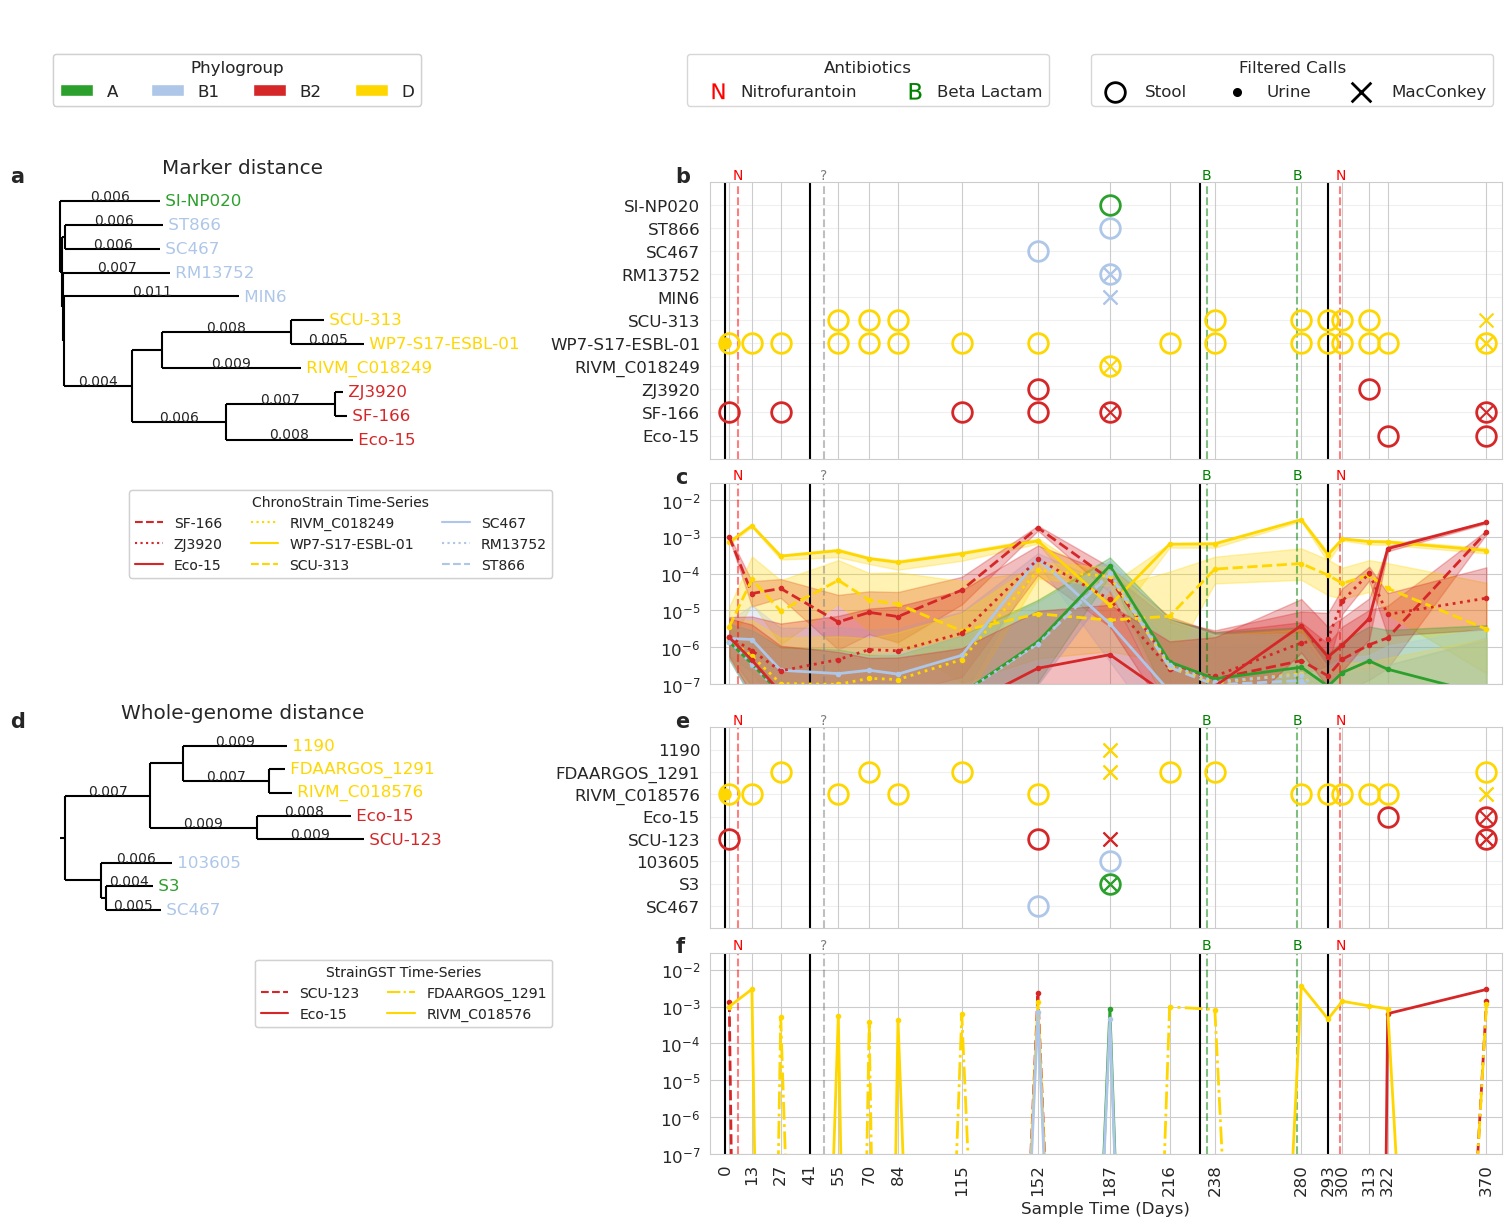

In [15]:
umb_id = 'UMB18'
plt.rcParams.update({'font.size': 12})
load_result(umb_id)


custom_linestyles_red = {
    'NZ_CP012633.1': {'linestyle': 'dashed'},  # SF-166
    'NZ_CP020545.1': {'linestyle': 'dotted'},  # ZJ3920
    'NZ_CP047710.1': {'linestyle': 'solid'},  # Eco-15
}
custom_linestyles_yellow = {
    'NZ_CP068802.1': {'linestyle': 'dotted'},  # RIVM_C018249
    'NZ_AP022173.1': {'linestyle': 'solid'},  # WP7-S17-ESBL-01
    'NZ_CP051694.1': {'linestyle': 'dashed'},  # SCU-313
}
custom_linestyles_lightblue = {
    'NZ_LR782232.1': {'linestyle': 'solid'},  # SC467
    'NZ_CP044311.1': {'linestyle': 'dotted'},  # RM13752
    'NZ_CP077646.1': {'linestyle': 'dashed'},  # ST866
}


custom_linestyles_red_straingst = {
    'NZ_CP051711.1': {'linestyle': 'dashed'},  # SCU-123
    'NZ_CP047710.1': {'linestyle': 'solid'},  # Eco-15
}
custom_linestyles_yellow_straingst = {
    # 'NZ_CP023386.1': {'linestyle': 'solid'},  # 1190
    'NZ_CP069980.1': {'linestyle': 'dashdot'},  # FDAARGOS_1291
    'NZ_CP068806.1': {'linestyle': 'solid'},  # RIVM_C018576
}

fig, gs = plot_umb(
    umb_id, base_dir, seed=31415, result_cache=res_cache, width=15.0, abund_lb=0.05,
    include_straingst=True,
    chronostrain_strain_linestyles=custom_linestyles_red | custom_linestyles_yellow | custom_linestyles_lightblue,
    straingst_strain_linestyles=custom_linestyles_red_straingst | custom_linestyles_yellow_straingst
)

# =========== linestyle legend
def render_linestyle_custom_legend(linestyle_dicts: List[Dict], style_ax, title):    
    style_ax.axis('off')
    handles = []
    labels = []
    empty_legend_handle = matplotlib.lines.Line2D([], [], marker='None', linestyle='None')
    
    plt.rcParams.update({'font.size': 10})
    n_items_per = np.max([len(d) for d in linestyle_dicts])
    for custom_linestyles_category in linestyle_dicts:
        for s_id, s_style in custom_linestyles_category.items():
            s_name = index_df.loc[index_df['Accession'] == s_id, 'Strain'].head(1).item()
            c = strain_colors[s_id]
            line = matplotlib.lines.Line2D([], [], color=c, **s_style)
            handles.append(line)
            labels.append(s_name)
        # Filler
        for _ in range(n_items_per - len(custom_linestyles_category)):
            handles.append(empty_legend_handle)
            labels.append("")
    
    style_legend = plt.legend(handles, labels, title=title, bbox_to_anchor=(1.3, 1.0), loc="upper right", ncol=len(linestyle_dicts))
    style_ax.add_artist(style_legend)
    plt.rcParams.update({'font.size': 12})


style_ax1 = fig.add_subplot(gs[2, 0])
render_linestyle_custom_legend([custom_linestyles_red, custom_linestyles_yellow, custom_linestyles_lightblue], style_ax1, title='ChronoStrain Time-Series')

style_ax2 = fig.add_subplot(gs[4, 0])
render_linestyle_custom_legend([custom_linestyles_red_straingst, custom_linestyles_yellow_straingst], style_ax2, title='StrainGST Time-Series')

# =========== save plot
plot_dir = Path() / 'plots'
plot_dir.mkdir(exist_ok=True)
plt.savefig(plot_dir / f'{umb_id}_both_methods_annotated.pdf', transparent=True, bbox_inches='tight')

# All UMB plots -- render

In [16]:
plt.rcParams.update({'font.size': 12})

# for umb_number in [14]:
for umb_number in range(1, 32):
    umb_id = 'UMB{}'.format(str(umb_number).zfill(2))    
    print(f"Rendering {umb_id}")
    load_result(umb_id)
    fig, gs = plot_umb(
        umb_id, base_dir, seed=31415, result_cache=res_cache, width=15.0, abund_lb=0.05,
        include_straingst=True
    )
    
    plot_dir = Path() / 'plots'
    plot_dir.mkdir(exist_ok=True)
    plt.savefig(plot_dir / f'{umb_id}_both_methods.pdf', transparent=True, bbox_inches='tight')
    plt.close(fig)

Rendering UMB01
30 of 1794 inference strains passed Posterior p(Z_s|Data) > 0.95
1 of 776 inference strains passed Posterior p(Z_s|Data) > 0.95
Found plate Esch_coli_UMB_01_01 -> timepoint_id 01
150 of 881 inference strains passed Posterior p(Z_s|Data) > 0.95
Found plate Esch_coli_UMB_01_01_2 -> timepoint_id 01
134 of 1021 inference strains passed Posterior p(Z_s|Data) > 0.95
Found plate Esch_coli_UMB_01_03 -> timepoint_id 03
135 of 913 inference strains passed Posterior p(Z_s|Data) > 0.95
Found plate Esch_coli_UMB_01_03_2 -> timepoint_id 03
122 of 1015 inference strains passed Posterior p(Z_s|Data) > 0.95
Rendering UMB02
25 of 1235 inference strains passed Posterior p(Z_s|Data) > 0.95
2 of 734 inference strains passed Posterior p(Z_s|Data) > 0.95
Rendering UMB03
119 of 1576 inference strains passed Posterior p(Z_s|Data) > 0.95
60 of 1594 inference strains passed Posterior p(Z_s|Data) > 0.95
Rendering UMB04
31 of 1498 inference strains passed Posterior p(Z_s|Data) > 0.95
File error whi

/home/youn/mambaforge/envs/chronostrain2/lib/python3.10/site-packages/scipy/special/_logsumexp.py:224: RuntimeWarning: invalid value encountered in subtract
  exp_x_shifted = np.exp(x - x_max)


Found plate Esch_coli_UMB_24_03 -> timepoint_id 03
File error while loading plate: Esch_coli_UMB_24_03
Found plate Esch_coli_UMB_24_03_2 -> timepoint_id 03
File error while loading plate: Esch_coli_UMB_24_03_2
Found plate Esch_coli_UMB_24_06 -> timepoint_id 06
File error while loading plate: Esch_coli_UMB_24_06
Found plate Esch_coli_UMB_24_08 -> timepoint_id 08
File error while loading plate: Esch_coli_UMB_24_08
Found plate Esch_coli_UMB_24_08_2 -> timepoint_id 08
File error while loading plate: Esch_coli_UMB_24_08_2
Rendering UMB25
28 of 1633 inference strains passed Posterior p(Z_s|Data) > 0.95
0 of 2 inference strains passed Posterior p(Z_s|Data) > 0.95


/home/youn/mambaforge/envs/chronostrain2/lib/python3.10/site-packages/scipy/special/_logsumexp.py:224: RuntimeWarning: invalid value encountered in subtract
  exp_x_shifted = np.exp(x - x_max)


Rendering UMB26
111 of 2173 inference strains passed Posterior p(Z_s|Data) > 0.95
0 of 7 inference strains passed Posterior p(Z_s|Data) > 0.95


/home/youn/mambaforge/envs/chronostrain2/lib/python3.10/site-packages/scipy/special/_logsumexp.py:224: RuntimeWarning: invalid value encountered in subtract
  exp_x_shifted = np.exp(x - x_max)


Rendering UMB27
49 of 1627 inference strains passed Posterior p(Z_s|Data) > 0.95
File error while loading urine: [Errno 2] No such file or directory: '/data/cctm/youn/umb/urine/UMB27/chronostrain/adhoc_cluster.txt'
Rendering UMB28
140 of 1748 inference strains passed Posterior p(Z_s|Data) > 0.95
0 of 37 inference strains passed Posterior p(Z_s|Data) > 0.95


/home/youn/mambaforge/envs/chronostrain2/lib/python3.10/site-packages/scipy/special/_logsumexp.py:224: RuntimeWarning: invalid value encountered in subtract
  exp_x_shifted = np.exp(x - x_max)


Rendering UMB29
44 of 1112 inference strains passed Posterior p(Z_s|Data) > 0.95
0 of 2 inference strains passed Posterior p(Z_s|Data) > 0.95


/home/youn/mambaforge/envs/chronostrain2/lib/python3.10/site-packages/scipy/special/_logsumexp.py:224: RuntimeWarning: invalid value encountered in subtract
  exp_x_shifted = np.exp(x - x_max)


Rendering UMB30
1 of 252 inference strains passed Posterior p(Z_s|Data) > 0.95
0 of 29 inference strains passed Posterior p(Z_s|Data) > 0.95


/home/youn/mambaforge/envs/chronostrain2/lib/python3.10/site-packages/scipy/special/_logsumexp.py:224: RuntimeWarning: invalid value encountered in subtract
  exp_x_shifted = np.exp(x - x_max)


Encountered singularity while plotting ABX vertical lines. Does a plot have height zero?
Encountered singularity while plotting Infection vertical lines. Does a plot have height zero?
Rendering UMB31
92 of 1749 inference strains passed Posterior p(Z_s|Data) > 0.95
0 of 5 inference strains passed Posterior p(Z_s|Data) > 0.95


/home/youn/mambaforge/envs/chronostrain2/lib/python3.10/site-packages/scipy/special/_logsumexp.py:224: RuntimeWarning: invalid value encountered in subtract
  exp_x_shifted = np.exp(x - x_max)


## What percentage of the genome are our markers?

In [81]:
x = []
for s in db.all_strains():
    if not s.metadata.species == 'coli':  # coli only
        continue
    marker_len = sum(len(m) for m in s.markers)
    ratio = marker_len / s.metadata.total_len
    x.append(ratio)
np.mean(x)

0.015044251863146507

# Whole-dataset plot -- timeseries correlation

In [22]:
umb_ids = ['UMB{}'.format(str(x).zfill(2)) for x in range(1, 32)]


for umb_id in umb_ids:
    print(f"loading {umb_id}")
    load_result(umb_id)
umb_results = list(x['stool'] for x in res_cache.values())
umb_results = [res for res in umb_results if res is not None]

loading UMB01
loading UMB02
loading UMB03
loading UMB04
loading UMB05
1 of 1382 inference strains passed BF Threshold > 100000.0
18 of 1913 inference strains passed BF Threshold > 100000.0
loading UMB06
4 of 2290 inference strains passed BF Threshold > 100000.0
File error while loading urine: [Errno 2] No such file or directory: '/data/cctm/youn/umb/urine/UMB06/chronostrain/adhoc_cluster.txt'
loading UMB07
23 of 1264 inference strains passed BF Threshold > 100000.0
File error while loading urine: [Errno 2] No such file or directory: '/data/cctm/youn/umb/urine/UMB07/chronostrain/adhoc_cluster.txt'
loading UMB08
53 of 1917 inference strains passed BF Threshold > 100000.0
10 of 1054 inference strains passed BF Threshold > 100000.0
Found plate Esch_coli_UMB_08_08 -> timepoint_id 08
93 of 982 inference strains passed BF Threshold > 100000.0
Found plate Esch_coli_UMB_08_08_2 -> timepoint_id 08
119 of 933 inference strains passed BF Threshold > 100000.0
Found plate Esch_coli_UMB_08_12 -> time

/home/youn/mambaforge/envs/chronostrain/lib/python3.10/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


loading UMB11
34 of 2077 inference strains passed BF Threshold > 100000.0
4 of 873 inference strains passed BF Threshold > 100000.0
Found plate Esch_coli_UMB_11_01 -> timepoint_id 01
58 of 1240 inference strains passed BF Threshold > 100000.0
Found plate Esch_coli_UMB_11_01_2 -> timepoint_id 01
53 of 1234 inference strains passed BF Threshold > 100000.0
Found plate Esch_coli_UMB_11_06 -> timepoint_id 06
14 of 886 inference strains passed BF Threshold > 100000.0
Found plate Esch_coli_UMB_11_06_2 -> timepoint_id 06
5 of 889 inference strains passed BF Threshold > 100000.0
Found plate Esch_coli_UMB_11_07 -> timepoint_id 07
57 of 1013 inference strains passed BF Threshold > 100000.0
loading UMB12
10 of 1759 inference strains passed BF Threshold > 100000.0
2 of 881 inference strains passed BF Threshold > 100000.0
Found plate Esch_coli_UMB_12_08 -> timepoint_id 08
32 of 862 inference strains passed BF Threshold > 100000.0
loading UMB13
23 of 1894 inference strains passed BF Threshold > 10000

/home/youn/mambaforge/envs/chronostrain/lib/python3.10/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


Found plate Esch_coli_UMB_24_03 -> timepoint_id 03
File error while loading plate: Esch_coli_UMB_24_03
Found plate Esch_coli_UMB_24_03_2 -> timepoint_id 03
File error while loading plate: Esch_coli_UMB_24_03_2
Found plate Esch_coli_UMB_24_06 -> timepoint_id 06
File error while loading plate: Esch_coli_UMB_24_06
Found plate Esch_coli_UMB_24_08 -> timepoint_id 08
File error while loading plate: Esch_coli_UMB_24_08
Found plate Esch_coli_UMB_24_08_2 -> timepoint_id 08
File error while loading plate: Esch_coli_UMB_24_08_2
loading UMB25
17 of 1633 inference strains passed BF Threshold > 100000.0
0 of 2 inference strains passed BF Threshold > 100000.0


/home/youn/mambaforge/envs/chronostrain/lib/python3.10/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


loading UMB26
36 of 2173 inference strains passed BF Threshold > 100000.0
0 of 7 inference strains passed BF Threshold > 100000.0
loading UMB27


/home/youn/mambaforge/envs/chronostrain/lib/python3.10/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


17 of 1627 inference strains passed BF Threshold > 100000.0
File error while loading urine: [Errno 2] No such file or directory: '/data/cctm/youn/umb/urine/UMB27/chronostrain/adhoc_cluster.txt'
loading UMB28
54 of 1748 inference strains passed BF Threshold > 100000.0
0 of 37 inference strains passed BF Threshold > 100000.0
loading UMB29


/home/youn/mambaforge/envs/chronostrain/lib/python3.10/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


19 of 1112 inference strains passed BF Threshold > 100000.0
0 of 2 inference strains passed BF Threshold > 100000.0
loading UMB30


/home/youn/mambaforge/envs/chronostrain/lib/python3.10/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


1 of 252 inference strains passed BF Threshold > 100000.0
0 of 29 inference strains passed BF Threshold > 100000.0


/home/youn/mambaforge/envs/chronostrain/lib/python3.10/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


loading UMB31
39 of 1749 inference strains passed BF Threshold > 100000.0
0 of 5 inference strains passed BF Threshold > 100000.0


/home/youn/mambaforge/envs/chronostrain/lib/python3.10/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


In [23]:
chronostrain_corr_df = analyze_chronostrain(
    umb_results,
    Path("/mnt/e/ecoli_db/phylogeny/ClermonTyping/umb_phylogroups_complete.txt"),
    0.05
)

Computing correlations for UMB18
Computing correlations for UMB01
Computing correlations for UMB02
Computing correlations for UMB03
Computing correlations for UMB04
Computing correlations for UMB05
Computing correlations for UMB06
Computing correlations for UMB07
Computing correlations for UMB08
Computing correlations for UMB09
Computing correlations for UMB10
Computing correlations for UMB11
Computing correlations for UMB12
Computing correlations for UMB13
Computing correlations for UMB14
Computing correlations for UMB15
Computing correlations for UMB16
Computing correlations for UMB17
Computing correlations for UMB19
Computing correlations for UMB20
Computing correlations for UMB21
Computing correlations for UMB22
Computing correlations for UMB23
Computing correlations for UMB24
Computing correlations for UMB25
Computing correlations for UMB26
Computing correlations for UMB27
Computing correlations for UMB28
Computing correlations for UMB29
Computing correlations for UMB30
Computing 

In [24]:
strainge_corr_df = analyze_strainge(
    straingst_df,
    pd.read_csv(Path().resolve().parent / 'files' / 'umb_samples.csv'),
    Path("/mnt/e/ecoli_db/phylogeny/ClermonTyping/umb_phylogroups_complete.txt")
)
display(strainge_corr_df)

,Patient,Phylogroup,Coherence,Abundance
0,UMB01,A,NaN,NaN
1,UMB01,F,NaN,NaN
2,UMB01,cladeI,NaN,NaN
3,UMB01,albertii,NaN,NaN
4,UMB01,Unknown,NaN,NaN
...,...,...,...,...
415,UMB31,G,NaN,NaN
416,UMB31,fergusonii,NaN,NaN
417,UMB31,E or cladeI,NaN,NaN
418,UMB31,B1,NaN,NaN


In [41]:
def half_circle(center, radius, color, angle=0, label=''):
    """
    Add two half circles to the axes *ax* (or the current axes) with the 
    specified facecolors *colors* rotated at *angle* (in degrees).
    """
    theta1, theta2 = angle, angle + 180
    w = matplotlib.patches.Wedge(center, radius, theta1, theta2, fc=color, edgecolor='black', linewidth=0.02, label=label)
    return w


def scatter_heatmap(
    df: pd.DataFrame, 
    ax, 
    row_name:str, 
    column_name: str, 
    color_name: str, 
    size_name: str, 
    circle_direction: str, 
    size_max: float, 
    size_min: float,
    colormap, norm,
    rows: List[str]=None, 
    columns: List[str]=None,
    nan_color='black'
):
    if rows is None:
        # Reverse row ordering
        pivot_df = df.pivot(index=row_name, columns=column_name, values=color_name)  # create only for initialization.
        ylabels = pivot_df.index.values.tolist()[::-1]
        del pivot_df
    else:
        ylabels = rows[::-1]

    if columns is None:
        # Reverse col ordering
        pivot_df = df.pivot(index=row_name, columns=column_name, values=color_name)  # create only for initialization.
        xlabels = pivot_df.columns.values.tolist()
        del pivot_df
    else:
        xlabels = columns

    n_rows = len(ylabels)
    n_cols = len(xlabels)
    x, y = np.meshgrid(np.arange(n_cols), np.arange(n_rows-1, -1, -1))

    def create_pivot(_value_name: str):
        pivoted = df.pivot(index=row_name, columns=column_name, values=_value_name)
        if rows is not None:
            for r in rows:
                if not (r in pivoted.index):
                    pivoted.loc[r] = np.nan
            row_index = {r: i for i, r in enumerate(rows)}
            pivoted = pivoted.sort_index(key=lambda r: r.map(row_index))

        if columns is not None:
            for c in columns:
                if not (c in pivoted.columns):
                    pivoted[c] = np.nan
            pivoted = pivoted[columns]
        return pivoted

    sizes = create_pivot(size_name)
    # display(sizes)
    sizes = np.log10(sizes)
    sizes = sizes.to_numpy()

    # linear re-scaling (place in [0, 1] interval)
    # sizes = sizes - size_offset
    # sizes = sizes / np.max(sizes)
    diameters = (sizes - size_min) / (size_max - size_min)
    diameters[np.isnan(diameters)] = 0.
    radii = diameters / 2

    colors = create_pivot(color_name)
    # display(colors)
    # colors = colors.fillna(0).to_numpy()
    colors = colors.to_numpy()
    if np.max(sizes) > 1.0:
        raise Exception(f"size value in column `{size_name}` of dataframe exceeded 1.0: {np.max(sizes)}")

    """ Full scatterplot. """
    # circles = [plt.Circle((_x, _y), radius=_r) for _r, _x, _y in zip(radii.flat, x.flat, y.flat)]
    # col = PatchCollection(circles, array=colors.flatten(), cmap=cmap, norm=matplotlib.colors.Normalize(vmin=0, vmax=1), edgecolor='black', linewidth=0.5)
    # ax.add_collection(col)

    """ Semicircle scatterplot. """
    if circle_direction == "left":
        angle = 90
        xoffset = -0.02
    else:
        angle = 270
        xoffset = 0.02

    circles = []

    for _r, _x, _y, _c in zip(radii.flat, x.flat, y.flat, colors.flat):
        if not np.isnan(_r) and _r > 0:
            if np.isnan(_c):
                circ = half_circle((_x + xoffset, _y), radius=_r, color=nan_color, angle=angle)
            else:
                circ = half_circle((_x + xoffset, _y), radius=_r, color=colormap(norm(_c)), angle=angle)
            circles.append(circ)
    for c in circles:
        ax.add_artist(c)

    """ Draw the rest of the labels. """
    ax.set(xticks=np.arange(n_cols), 
           yticks=np.arange(n_rows),
           xticklabels=xlabels, 
           yticklabels=ylabels)
    ax.set_xticklabels(xlabels, rotation=90, horizontalalignment='center', verticalalignment='top')
    ax.set_xticks(np.arange(n_cols + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(n_rows + 1) - 0.5, minor=True)
    ax.grid(False)
    ax.grid(which='minor', alpha=0.3)
    ax.tick_params('both', length=0)
    ax.tick_params('both', which='minor', length=0)


def coherence_breakdown(
    fig, ax, phylogroups, chronostrain_corr_df, straingst_corr_df,
    circle_ax, diam_ax, cbar_ax,
    nan_color='black',
):
    # Calculate mutual minimum.
    # _x = np.log10(straingst_corr_df['Abundance'].to_numpy())
    # display(_x[~np.isnan(_x)])
    all_sizes = np.concatenate([
        chronostrain_corr_df['Abundance'].to_numpy(),
        straingst_corr_df['Abundance'].to_numpy()
    ])
    min_size = np.min(all_sizes[~np.isnan(all_sizes) & (all_sizes > 1e-5)])
    min_size = np.log10(min_size)

    # manual setting!
    # min_size = -5.0

    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    colormap = matplotlib.colormaps['RdBu']
    scatter_heatmap(
        df=chronostrain_corr_df,
        row_name='Phylogroup',
        rows=phylogroups,
        column_name='Patient',
        columns=["UMB{}".format(str(x).zfill(2)) for x in range(1, 32, 1)],
        color_name='Coherence',
        size_name='Abundance',
        circle_direction='left',
        ax=ax,
        colormap=colormap, norm=norm,
        size_max=0,
        size_min=min_size,
        nan_color=nan_color,
    )
    scatter_heatmap(
        df=straingst_corr_df,
        row_name='Phylogroup',
        rows=phylogroups,
        column_name='Patient',
        columns=["UMB{}".format(str(x).zfill(2)) for x in range(1, 32, 1)],
        color_name='Coherence',
        size_name='Abundance',
        circle_direction='right',
        ax=ax,
        colormap=colormap, norm=norm,
        size_max=0,
        size_min=min_size,
        nan_color=nan_color,
    )

    legend_elements = [
        half_circle((3.5, 1), 1.1, 'tab:blue', angle=90, label='ChronoStrain'),
        half_circle((-3.5, 1), 1.1, 'tab:blue', angle=270, label='StrainGST')
    ]

    class _LegendHandler(HandlerPatch):
        def create_artists(self, legend, orig_handle,
                           xdescent, ydescent, width, height, fontsize, trans):
            x, y = orig_handle.center
            p = matplotlib.patches.Wedge(center=(10 + x, 1.5 + y), r=6.5 * orig_handle.r, theta1=orig_handle.theta1, theta2=orig_handle.theta2)
            self.update_prop(p, orig_handle, legend)
            p.set(linewidth=0.4)
            p.set_transform(trans)
            return [p]

    ax.set_ylabel("Phylogroup")
    ax.set_xlabel("Patient")

    # circle_ax = fig.add_axes([0.6, -0.005, 0.18, 0.026])
    circle_ax.axis('off')
    circle_ax.legend(
        handles=legend_elements, 
        markerfirst=False,
        handler_map={matplotlib.patches.Wedge: _LegendHandler()}
    )

    # diam_ax = fig.add_axes([0.4, -0.005, 0.18, 0.026])
    x = [0.0,1.0,1.0,0.0]
    y = [0.0,0.0,1.0,0.0]
    diam_ax.add_patch(patches.Polygon(xy=list(zip(x,y)), edgecolor='black', facecolor='white', fill=True))
    diam_ax.plot([0.5, 0.5], [0.0, 0.5], color='black', marker=None)
    diam_ax.text(0, -0.8, "$\leq 10^{{{:.1f}}}$".format(min_size), {'ha': 'center'})
    diam_ax.text(0.5, -0.8, "$10^{{{:.1f}}}$".format(min_size / 2), {'ha': 'center'})
    diam_ax.text(1, -0.8, "1.0", {'ha': 'center'})
    diam_ax.text(0.5, -1.5, "Abundance (Diameter)", {'ha': 'center'})
    diam_ax.axis('off')


    # cbar_ax = fig.add_axes([0.15, -0.005, 0.2, 0.02])
    fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=colormap), 
        cax=cbar_ax, label=r"Time-Delayed Spearman-$\rho$", orientation="horizontal"
    )

In [42]:
def apply_statistical_test(df, is_paired: bool):
    test_type = 'Paired_Wilcoxon' if is_paired else 'Unpaired_MannWhitneyU'


    _methods = set(pd.unique(df['Method']))
    clade = df['Phylogroup'].head(1).item()
    if 'ChronoStrain' not in _methods and 'StrainGE' not in _methods:
        print("Both outputs empty for clade `{}`".format(clade))
        stat, p, x, y = np.nan, np.nan, [], []
    elif 'ChronoStrain' not in _methods:
        print("ChronoStrain output empty for clade `{}`".format(clade))
        stat = np.nan
        p = np.nan
        x = []
        y = df['Coherence'].dropna().tolist()
    elif 'StrainGE' not in _methods:
        print("StrainGE output empty for clade `{}`".format(clade))
        stat = np.nan
        p = np.nan
        x = df['Coherence'].dropna().tolist()
        y = []
    else:
        pivoted = df.pivot(index="Patient", columns="Method", values="Coherence")
        pivoted = pivoted.dropna(axis=0, how = 'all')

        if is_paired: 
            # ==== paired test ==================
            x = pivoted.dropna()['ChronoStrain']
            y = pivoted.dropna()['StrainGE']

            if len(x) == 0 or len(y) == 0 or np.sum(x - y != 0) == 0:
                stat = np.nan
                p = np.nan
                n = 0
            else:
                stat, p = scipy.stats.wilcoxon(
                    x=x, y=y,
                    alternative='two-sided',
                    zero_method='wilcox'
                )
            # ==================================
        else:
            # ==== unpaired test ==================
            x = pivoted['ChronoStrain'].dropna()
            y = pivoted['StrainGE'].dropna()
            print("Performing unpaired test.")

            if len(x) == 0 or len(y) == 0:
                stat = np.nan
                p = np.nan
            else:
                stat, p = scipy.stats.mannwhitneyu(
                    x=x, y=y,
                    alternative='two-sided'
                )
            # ==================================

    return pd.Series({'Pvalue': p, 'Stat': stat, 'SampleSizeX': len(x), 'SampleSizeY': len(y), 'Test': test_type})

ChronoStrain output empty for clade `Unknown`
ChronoStrain output empty for clade `albertii`
ChronoStrain output empty for clade `cladeV`
ChronoStrain output empty for clade `fergusonii`
N tests = 5


,Pvalue,Stat,SampleSizeX,SampleSizeY,Test,PvalueAdj,BHSig
Phylogroup,,,,,,,
B2,0.004883,3.0,11,11,Paired_Wilcoxon,0.019531,True
A,0.007812,0.0,8,8,Paired_Wilcoxon,0.019531,True
D,0.109375,4.0,7,7,Paired_Wilcoxon,0.182292,False
B1,1.000000,1.0,2,2,Paired_Wilcoxon,1.000000,False
G,1.000000,0.0,1,1,Paired_Wilcoxon,1.000000,False


/home/youn/mambaforge/envs/chronostrain/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


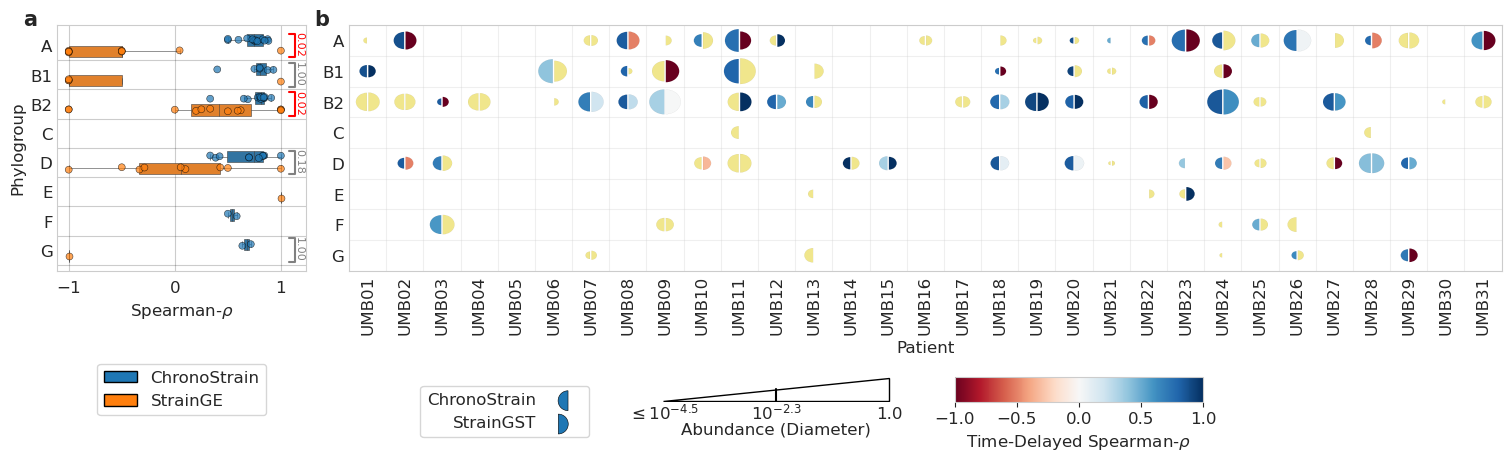

In [43]:
fig = plt.figure(constrained_layout=True, figsize=(15, 4.5))
gs = gridspec.GridSpec(ncols=5, nrows=2, figure=fig, width_ratios=[1, 1, 1, 1, 1], height_ratios=[10, 1])

plt.rcParams.update({'font.size': 12})

phylogroups_to_show = ['A', 'B1', 'B2', 'C', 'D', 'E', 'F', 'G']
boxplot_ax = fig.add_subplot(gs[0, :1])
method_palette = {'ChronoStrain': 'tab:blue', 'StrainGE': 'tab:orange'}

# =================== panel A
concat_res = pd.concat([
    chronostrain_corr_df.assign(Method='ChronoStrain'),
    strainge_corr_df.assign(Method='StrainGE'),
], ignore_index=True)
sb.boxplot(
    concat_res,
    hue='Method',
    palette=method_palette,
    y='Phylogroup',
    x='Coherence',
    ax=boxplot_ax,
    order=phylogroups_to_show,
    showfliers=False,
    linewidth=0.4
)
sb.stripplot(
    concat_res,
    hue='Method',
    palette=method_palette,
    y='Phylogroup',
    x='Coherence',
    dodge=True,
    ax=boxplot_ax,
    order=phylogroups_to_show,
    edgecolor='black',
    linewidth=0.4,
    alpha=0.7
)
boxplot_ax.minorticks_on()
boxplot_ax.tick_params('y', length=0)
boxplot_ax.tick_params('y', which='minor', length=0)
boxplot_ax.set_yticks(list(range(len(phylogroups_to_show))))
boxplot_ax.set_yticks(
    np.array(list(range(len(phylogroups_to_show)))) + 0.5,
    minor=True
)
boxplot_ax.grid(which='minor', axis='y', color='black', alpha=0.2)
boxplot_ax.get_legend().set_visible(False)
boxplot_ax.set_xlabel(r'Spearman-$\rho$')

boxplot_legend_ax = fig.add_subplot(gs[1, 0])
legend_elements = [
    patches.Patch(facecolor=color, edgecolor='black', label=method)
    for method, color in method_palette.items()
]
boxplot_legend_ax.legend(handles=legend_elements, loc='center')
boxplot_legend_ax.axis('off')

# ======================= panel A, p-values
DO_PAIRED_TEST = True

pvalues = concat_res.groupby(["Phylogroup"]).apply(lambda x: apply_statistical_test(x, DO_PAIRED_TEST)).astype({'SampleSizeX': int, 'SampleSizeY': int})
def benjamini_hochberg(df: pd.DataFrame, pvalue_column: str = 'Pvalue', target_column: str = 'BHSignificant'):
    df = df.sort_values(pvalue_column, ascending=True).dropna()

    n_tests = df.shape[0]
    print(f"N tests = {n_tests}")
    rank = np.arange(1, n_tests + 1, 1)

    adjusted_pvals = df[pvalue_column].to_numpy() * n_tests / rank
    for i in range(n_tests):
        adjusted_pvals[i] = np.min(adjusted_pvals[i:])
    df[f'{pvalue_column}Adj'] = adjusted_pvals
    return df


FDR = 0.05
bh_adjusted = benjamini_hochberg(pvalues)
display(bh_adjusted.assign(BHSig=bh_adjusted['PvalueAdj'] < FDR))

# ===== Render pvalues
# Helper function
def _annotate(ax, clade: str, x: float, h: float, significant: bool, pmarker: str):
    clade_idxs = {c: i for i, c in enumerate(phylogroups_to_show)}
    if clade not in clade_idxs:
        return

    clade_idx = clade_idxs[clade]

    _delta = 0.4
    y1, y2 = clade_idx - _delta, clade_idx + _delta

    if significant:
        color = 'red'
        ax.plot([x, x+h, x+h, x], [y1, y1, y2, y2], lw=1.5, c=color)
        ax.text(x+h+0.04, clade_idx - 0.05, pmarker, ha='center', va='center', color=color, size=8, rotation=270)
    else:
        color = 'gray'
        ax.plot([x, x+h, x+h, x], [y1, y1, y2, y2], lw=1.5, c=color)
        ax.text(x+h+0.04, clade_idx - 0.05, pmarker, ha='center', va='center', color=color, size=8, rotation=270)

for clade, r in bh_adjusted.iterrows():
    p = r['PvalueAdj']
    if np.isnan(p):
        continue
    else:
        is_significant = p < FDR
        # plabel = "*"
        plabel = r"{:.2f}".format(p)
        _annotate(boxplot_ax, clade, x=1.08, h=0.05, pmarker=plabel, significant=is_significant)


# =================== panel B
scatter_ax = fig.add_subplot(gs[0, 1:])
circle_ax = fig.add_subplot(gs[1, 1])
diam_ax = fig.add_subplot(gs[1, 2])
cbar_ax = fig.add_subplot(gs[1, 3])
coherence_breakdown(
    fig, scatter_ax,
    phylogroups_to_show,
    chronostrain_corr_df,
    strainge_corr_df,
    circle_ax, 
    diam_ax, 
    cbar_ax,
    nan_color='khaki'
)
scatter_ax.set_ylabel(None)

add_figure_labels(
    fig, [boxplot_ax, scatter_ax]
)


plot_dir = Path() / 'plots'
plot_dir.mkdir(exist_ok=True)
plt.savefig(plot_dir / 'umb_summary.pdf')

# UMB18 macconkey abundance

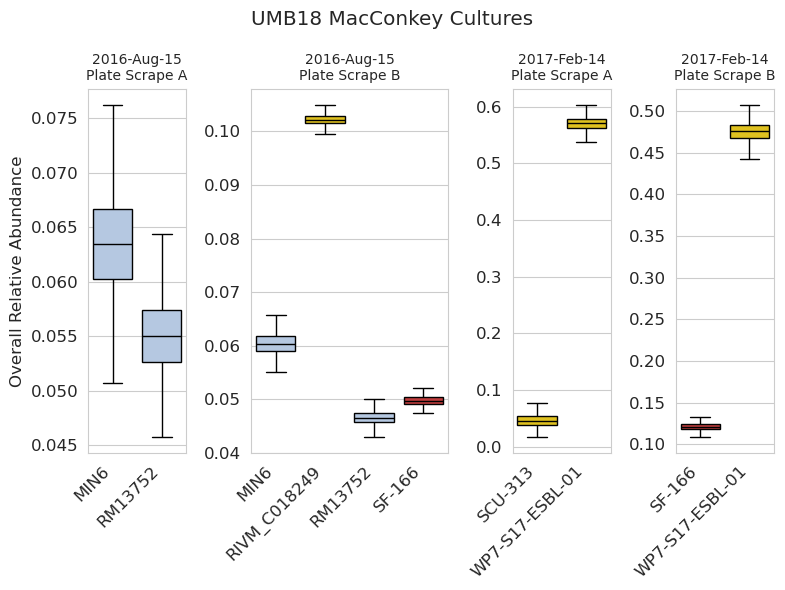

In [43]:
culture_dfs = []
for (_t, _res) in res_cache['UMB18']['plate']:
    _df = _res.annot_df_with_lower_bound(0.05, Taxon('Escherichia', 'coli'))
    overall_relabund = _res.overall_ra()
    filt_relabund = _res.filt_ra()
    df_entries = []
    for s_idx in pd.unique(_df['StrainIdx']):
        strain = _res.display_strains[s_idx]
        ra_samples = overall_relabund[0, :, s_idx]
        filt_ra_samples = filt_relabund[0, :, s_idx]
        for i, (abund, filt_abund) in enumerate(zip(ra_samples, filt_ra_samples)):
            df_entries.append({
                'Strain': strain.name,
                'SampleIdx': i,
                'OverallAbund': abund,
                'FilterAbund': filt_abund
            })
    culture_dfs.append((_t, pd.DataFrame(df_entries)))
    del df_entries

fig, axes = plt.subplots(
    1, 4, 
    figsize=(8, 6), 
    gridspec_kw={
        'width_ratios': [len(pd.unique(df['Strain'])) for _, df in culture_dfs]
    }
)
for (_t, culture_df), ax, plate_id in zip(culture_dfs, axes, ['A', 'B', 'A', 'B']):
    strain_order = sorted(pd.unique(culture_df['Strain']))
    sb.boxplot(
        culture_df,
        x='Strain', hue='Strain', order=strain_order,
        y='OverallAbund',
        ax=ax,
        palette={s.name: phylo_colors[s.phylogroup] for s in db.all_strains()},
        showfliers=False
    )
    ax.set_xticks(strain_order)
    ax.set_xticklabels(strain_order, rotation=45, ha="right")
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    date_obj = umb_dates_df.loc[
        (umb_dates_df['Patient'] == 'UMB18')
        & (umb_dates_df['T'] == _t),
        'Date'
    ].head(1).item()
    date_str = date_obj.strftime("%Y-%b-%d")
    ax.set_title(f"{date_str}\nPlate Scrape {plate_id}", size=10)
    
axes[0].set_ylabel("Overall Relative Abundance")


fig.suptitle(f"UMB18 MacConkey Cultures")
fig.tight_layout()

plt.savefig("plots/UMB18_macconkey_abundances.pdf")

# Tables for Zenodo export

In [129]:
all_chr_df = []
for umb_number in range(1, 32):
    umb_id = 'UMB{}'.format(str(umb_number).zfill(2))    
    load_result(umb_id)

    res = res_cache[umb_id]
    stool_result = res['stool']
    urine_result = res.get('urine', None)
    plate_results = res.get('plate', [])
    
    seed=31415
    width=15.0
    abund_lb=0.05
    
    plotter = ChronostrainRenderer(
        db=db,
        cluster_path=cluster_path,
        abund_lb=abund_lb, 
        target_taxon=Taxon("Escherichia", "coli"), 
        strain_palette=strain_colors,
        stool_result=stool_result,
        urine_result=urine_result,
        plate_results=plate_results,
        abx_df=load_abx_df(umb_id),
        abx_palette=abx_colors,
        abx_label=abx_acronym,
        uti_df=load_uti_df(umb_id),
        sample_df=load_sample_df(umb_id)
    )
    chr_df = plotter.get_merged_df()
    all_chr_df.append(chr_df.assign(Participant=umb_id))

all_chr_df = pd.concat(all_chr_df, ignore_index=True)
all_chr_df['Phylogroup'] = all_chr_df['StrainId'].map({s.id: s.phylogroup for s in db.all_strains()})

In [135]:
Path("zenodo").mkdir(exist_ok=True, parents=True)
all_chr_df[
    [
        'Participant', 'T', 'Src', 'StrainIdx', 'StrainId', 'Phylogroup',
        'Genus', 'Species', 'StrainName', 'PosteriorProb',
        'FilterRelAbundLower', 'FilterRelAbundMedian', 'FilterRelAbundUpper', 
        'OverallRelAbundLower', 'OverallRelAbundMedian', 'OverallRelAbundUpper',
    ]
].to_csv("zenodo/chronostrain_all_threhsolded.tsv", sep='\t', index=False)

In [136]:
straingst_df.merge(
    umb_dates_df,
    on=['Patient', 'SampleName', 'Date'],
    how='left'
).rename(
    columns={'Patient': 'Participant'}
)

,Participant,SampleName,Date,StrainName,Species,StrainId,Phylogroup,RelAbund,T,Src
0,UMB01,UMB01_00,2015-10-26,FDAARGOS_1254,coli,NZ_CP069453.1,B2,0.00080,298.0,Stool
1,UMB01,UMB01_00,2015-10-26,CFS3313,coli,NZ_CP026939.2,B1,0.00071,298.0,Stool
2,UMB01,UMB01_00urt,2015-10-27,PK8566,coli,NZ_CP080172.1,B1,0.33710,299.0,Urine
3,UMB01,UMB01_01,2015-11-11,CFS3313,coli,NZ_CP026939.2,B1,0.00179,314.0,Stool
4,UMB01,UMB01_03,2016-01-06,FDAARGOS_1254,coli,NZ_CP069453.1,B2,0.01637,370.0,Stool
...,...,...,...,...,...,...,...,...,...,...
363,UMB24,UMB_24_03_2,2016-06-14,SJC33,coli,NZ_CP080255.1,D,0.23513,530.0,Plate
364,UMB24,UMB_24_06,2016-09-13,0H25,coli,NZ_CP081690.1,A,0.22341,621.0,Plate
365,UMB24,UMB_24_06,2016-09-13,SJC33,coli,NZ_CP080255.1,D,0.61603,621.0,Plate
366,UMB24,UMB_24_08,2016-11-15,RIVM_C018576,coli,NZ_CP068806.1,D,0.87950,684.0,Plate


In [137]:
straingst_df.merge(
    umb_dates_df,
    on=['Patient', 'SampleName', 'Date'],
    how='left'
).rename(
    columns={'Patient': 'Participant'}
)[
    [
        'Participant', 'T', 'Date', 'Src', 'SampleName', 'StrainId', 'Phylogroup',
        'Species', 'StrainName',
        'RelAbund'
    ]
].to_csv("zenodo/straingst_all_threhsolded.tsv", sep='\t', index=False)